# Maxcut problem

## **Step 0**: Setup

In [1]:
# General imports
import math
import numpy as np

# Qiskit ansatz circuits
from qiskit.circuit.library import RealAmplitudes

# Qiskit primitives
from qiskit.primitives import Estimator as QiskitEstimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.primitives import Sampler as QiskitSampler
from qiskit_aer.primitives import Sampler as AerSampler

# Qiskit runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# quadratic_program
from quadratic_program import QuadraticProgram

# Docplex - classical description of optimization problems
from docplex.mp.model import Model

# translations
from translators import docplex_mp_to_qp
from translators import qubo_to_sparse_pauli_op

# workflows 
from workflows import QuadraticProgramPostprocess, QuadraticProgramConverter

# SPSA
from spsa import minimize_spsa

# rustworkx graph library
import rustworkx as rs
from rustworkx.visualization import mpl_draw

## Load the Runtime (if using)

In [2]:
service = QiskitRuntimeService()

In [3]:
backend = service.get_backend('ibm_kyiv')


## **Step 1** Map the problem to a Quantum Native format (Set of Operators, and a set of Quantum Circuits)

Specify optimization problem using docplex and convert to Quadratic Unconstained Binary Opimization (QUBO) problem that can be cast as an Ising Hamiltonian suitable for a quantum solution.

In [4]:
def random_adjacency_graph(N, density=0.5):
    """Build random adjacency graph of a given density

    Parameters:
        N (int): Matrx dimension
        density (float): Density of non-zero elements, default=0.5

    Returns:
        ndarray: Adjacency matrix as NumPy array
    """
    off_elems = N*(N-1)//2
    num_elems = math.ceil(off_elems * density)
    inds = np.sort(np.random.choice(off_elems, size=num_elems, replace=False))

    M = np.zeros((N, N), dtype=float)
    for k in inds:
        i = N - 2 - int(math.sqrt(-8*k + 4*N*(N-1)-7)/2 - 0.5)
        j = (k + i + 1 - N*(N-1)//2 + (N-i)*((N-i)-1)//2)
        M[i,j] = 1

    M = M + M.T
    return M

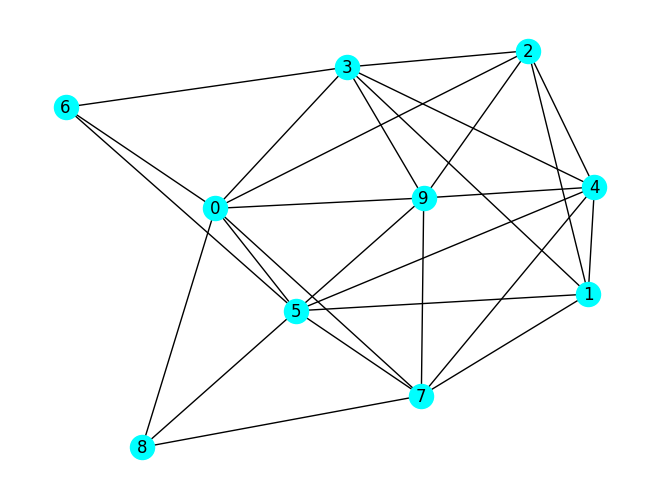

In [5]:
N = 10
density = 0.6
M = random_adjacency_graph(N, density)

G = rs.PyGraph.from_adjacency_matrix(M)
mpl_draw(G, with_labels=True, node_color='cyan')

In [6]:
mdl = Model(name="Max-cut")
x = {i: mdl.binary_var(name=f"x_{i}") for i in range(G.num_nodes())}
objective = mdl.sum(w * x[i] * (1 - x[j]) + w * x[j] * (1 - x[i]) for i, j, w in G.weighted_edge_list())
mdl.maximize(objective)
#print(mdl.export_as_lp_string())

### Convert to our `QuadraticProgram` format

In [7]:
qp = docplex_mp_to_qp(mdl)
#print(qp.prettyprint())

### Classical transformation to QUBO problem and Ising Hamiltonian

In [8]:
quadratic_transformer = QuadraticProgramConverter()
qubo = quadratic_transformer.run(qp)
#print(qubo.prettyprint())

In [9]:
hamiltonian, offset = qubo_to_sparse_pauli_op(qubo)

### Select ansatz circuit from circuit library

In [10]:
ansatz = RealAmplitudes(hamiltonian.num_qubits, entanglement = 'linear', reps=2)
print(ansatz.decompose())

     ┌──────────┐     ┌───────────┐                          ┌───────────┐»
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[10]) ├───────────────────■──────┤ Ry(θ[20]) ├»
     ├──────────┤┌─┴─┐└───────────┘┌───────────┐    ┌─┴─┐    └───────────┘»
q_1: ┤ Ry(θ[1]) ├┤ X ├──────■──────┤ Ry(θ[11]) ├────┤ X ├──────────■──────»
     ├──────────┤└───┘    ┌─┴─┐    └───────────┘┌───┴───┴───┐    ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├─────────┤ X ├──────────■──────┤ Ry(θ[12]) ├────┤ X ├────»
     ├──────────┤         └───┘        ┌─┴─┐    └───────────┘┌───┴───┴───┐»
q_3: ┤ Ry(θ[3]) ├──────────────────────┤ X ├──────────■──────┤ Ry(θ[13]) ├»
     ├──────────┤                      └───┘        ┌─┴─┐    └───────────┘»
q_4: ┤ Ry(θ[4]) ├───────────────────────────────────┤ X ├──────────■──────»
     ├──────────┤                                   └───┘        ┌─┴─┐    »
q_5: ┤ Ry(θ[5]) ├────────────────────────────────────────────────┤ X ├────»
     ├──────────┤                                                └───┘    »
q_6: ┤ Ry(θ[

## **Step 2**: Optimize the circuits and the operators to be measured

In [11]:
from qiskit.compiler import transpile
ansatz_ibm = transpile(ansatz, backend=backend, optimization_level=3, scheduling_method='alap')
print(ansatz_ibm.depth())

25


In [12]:
# Dynamical decoupling imports
from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling

durations = InstructionDurations.from_backend(backend)
constraints = backend.configuration().timing_constraints

In [13]:
# CPMG sequence
dd_sequence = [XGate(), XGate()]
# Fraction of duration to place in-between DD sequence gates
spacing = [1/4, 1/2, 1/4]

In [14]:
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence, spacing=spacing,
                                         pulse_alignment=constraints['pulse_alignment'])])

In [15]:
dd_circs = pm.run(ansatz_ibm)
dd_circs.draw(idle_wires=False)

global phase: π
              ┌────┐       ┌──────────────┐     ┌────┐     ┌────────┐          »
 q_95: ───────┤ √X ├───────┤ Rz(θ[0] + π) ├─────┤ √X ├─────┤ Rz(3π) ├────■─────»
              ├────┤       ├──────────────┤     ├────┤     ├────────┤  ┌─┴─┐   »
 q_96: ───────┤ √X ├───────┤ Rz(θ[1] + π) ├─────┤ √X ├─────┤ Rz(3π) ├──┤ X ├───»
       ┌──────┴────┴─────┐ └────┬────┬────┘┌────┴────┴────┐└─┬────┬─┘┌─┴───┴──┐»
 q_97: ┤ Delay(2976[dt]) ├──────┤ √X ├─────┤ Rz(θ[2] + π) ├──┤ √X ├──┤ Rz(3π) ├»
       ├─────────────────┤      ├────┤     ├──────────────┤  ├────┤  ├────────┤»
 q_98: ┤ Delay(6176[dt]) ├──────┤ √X ├─────┤ Rz(θ[3] + π) ├──┤ √X ├──┤ Rz(3π) ├»
       ├─────────────────┤      ├────┤     ├──────────────┤  ├────┤  ├────────┤»
 q_99: ┤ Delay(8928[dt]) ├──────┤ √X ├─────┤ Rz(θ[4] + π) ├──┤ √X ├──┤ Rz(3π) ├»
       ├─────────────────┴┐     ├────┤     ├──────────────┤  ├────┤  ├────────┤»
q_100: ┤ Delay(11680[dt]) ├─────┤ √X ├─────┤ Rz(θ[5] + π) ├──┤ √X ├──┤ Rz(3π) ├»
       ├──────────────────┤     ├────┤     ├──────────────┤  ├────┤  ├────────┤»
q_110: ┤ Delay(14656[dt]) ├─────┤ √X ├─────┤ Rz(θ[6] + π) ├──┤ √X ├──┤ Rz(3π) ├»
       ├──────────────────┤     ├────┤     ├──────────────┤  ├────┤  ├────────┤»
q_118: ┤ Delay(17632[dt]) ├─────┤ √X ├─────┤ Rz(θ[7] + π) ├──┤ √X ├──┤ Rz(3π) ├»
       ├──────────────────┤     ├────┤     ├──────────────┤  ├────┤  ├────────┤»
q_119: ┤ Delay(20384[dt]) ├─────┤ √X ├─────┤ Rz(θ[8] + π) ├──┤ √X ├──┤ Rz(3π) ├»
       ├──────────────────┤     ├────┤     ├──────────────┤  ├────┤  ├────────┤»
q_120: ┤ Delay(23136[dt]) ├─────┤ √X ├─────┤ Rz(θ[9] + π) ├──┤ √X ├──┤ Rz(3π) ├»
       └──────────────────┘     └────┘     └──────────────┘  └────┘  └────────┘»
«       ┌────────────────┐      ┌───┐       ┌─────────────────┐┌───┐ »
« q_95: ┤ Delay(624[dt]) ├──────┤ X ├───────┤ Delay(1280[dt]) ├┤ X ├─»
«       └────────────────┘      ├───┴┐      └┬───────────────┬┘├───┴┐»
« q_96: ────────■───────────────┤ √X ├───────┤ Rz(θ[11] + π) ├─┤ √X ├»
«             ┌─┴─┐       ┌─────┴────┴─────┐ └───────────────┘ ├────┤»
« q_97: ──────┤ X ├───────┤ Delay(224[dt]) ├─────────■─────────┤ √X ├»
«             └───┘       └────────────────┘       ┌─┴─┐       └────┘»
« q_98: ───────────────────────────────────────────┤ X ├─────────■───»
«                                                  └───┘       ┌─┴─┐ »
« q_99: ───────────────────────────────────────────────────────┤ X ├─»
«                                                              └───┘ »
«q_100: ─────────────────────────────────────────────────────────────»
«                                                                    »
«q_110: ─────────────────────────────────────────────────────────────»
«                                                                    »
«q_118: ─────────────────────────────────────────────────────────────»
«                                                                    »
«q_119: ─────────────────────────────────────────────────────────────»
«                                                                    »
«q_120: ─────────────────────────────────────────────────────────────»
«                                                                    »
«       ┌────────────────┐┌────┐┌───────────────┐       ┌────┐     ┌────────┐»
« q_95: ┤ Delay(624[dt]) ├┤ √X ├┤ Rz(θ[10] + π) ├───────┤ √X ├─────┤ Rz(3π) ├»
«       └───┬────────┬───┘└────┘└───────────────┘       └────┘     └────────┘»
« q_96: ────┤ Rz(3π) ├───────────────────────────────────────────────────────»
«       ┌───┴────────┴──┐ ┌────┐    ┌────────┐                               »
« q_97: ┤ Rz(θ[12] + π) ├─┤ √X ├────┤ Rz(3π) ├───────────────────────────────»
«       ├───────────────┴┐├────┤┌───┴────────┴──┐       ┌────┐     ┌────────┐»
« q_98: ┤ Delay(224[dt]) ├┤ √X ├┤ Rz(θ[13] + π) ├───────┤ √X ├─────┤ Rz(3π) ├»
«       └────────────────┘├────┤├───────────────┤       ├────┤     ├────────┤»
« q_99: ────────■─────────┤ √X ├┤ Rz(θ[14] + π) ├───────┤ √X ├─────┤ Rz(3π) ├»
« 

In [16]:
from permute_sparse_pauli_op import permute_sparse_pauli_op

layout = ansatz_ibm.layout.initial_layout
hamiltonian_ibm = permute_sparse_pauli_op(hamiltonian,layout, ansatz.qubits)

## **Step 3**: Execute using a quantum primitive function (estimator or sampler)

### Standard cost function definition

In [17]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

### Setup estimator and sampler instances

In [18]:
#session = Session(backend=backend)
#estimator = Estimator(session=session, options={"shots": int(1e4)})
#sampler = Sampler(session=session, options={"shots": int(1e4)})
#estimator = QiskitEstimator(options={"shots": int(1e4)})
#sampler = QiskitSampler(options={"shots": int(1e4)})

estimator = AerEstimator()
sampler = AerSampler()

### Perform minimization

In [19]:
x0 = 2*np.pi*np.random.random(size=dd_circs.num_parameters)
res = minimize_spsa(cost_func, x0, args=(dd_circs, hamiltonian_ibm, estimator), maxiter=5)
res

 message: Optimization terminated successfully.
 success: True
     fun: -0.0224609375
       x: [ 1.767e+00  2.612e+00 ...  3.378e+00  1.970e+00]
     nit: 5
    nfev: 10

### Computute distribution at found minimum

In [20]:
# Assign solution parameters to ansatz
qc = dd_circs.assign_parameters(res.x)
qc.measure_all()
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
#session.close()

## **Step 4**: Post-processing of the results to return either a plot or the answer
Transform quantum solution and convert back into classical variable space

In [21]:
solution =QuadraticProgramPostprocess(qubo, quadratic_transformer).run(samp_dist)
solution

QuadraticProgramError: 'The number of variables in the passed result differs from that of the original problem, should be 10, but got 127.'

## Intepretation of solution

In [ ]:
mpl_draw(G, with_labels=True, 
         node_color=['cyan' if kk else 'violet' for kk in solution])